## Grover Search for Combinatorial Problems


Original version : https://github.com/qiskit/qiskit-tutorial, Giacomo Nannicini and Rudy Raymond (based on [this paper](https://arxiv.org/abs/1708.03684)) 

Modified: Hyeongrak Choi (Chuck, choihr@mit.edu)

## Introduction

Grover search is one of the most popular algorithms used for searching a solution among many possible candidates using Quantum Computers. If there are $N$ possible solutions among which there is exactly one solution (that can be verified by some function evaluation), then Grover search can be used to find the solution with $O(\sqrt{N})$ function evaluations. This is in contrast to classical computers that require $\Omega(N)$ function evaluations: the Grover search is a quantum algorithm that provably can be used search the correct solutions quadratically faster than its classical counterparts.  

Here, we are going to illustrate the use of Grover search to solve a combinatorial problem called [Exactly-1 3-SAT problem](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem#Exactly-1_3-satisfiability). The Exactly-1 3-SAT problem is a NP-complete problem, namely, it is one of the most difficult problems that are interconnected (meaning that if we solve any one of them, we essentially can solve all of them). Unfortunately, there are many natural problems that are NP-complete, such as, the Traveling Salesman Problem (TSP), the Maximum Cut (MaxCut) and so on. Up to now, there is no classical and quantum algorithm that can efficiently solve such NP-hard problems. 

We begin with an example of the Exactly-1 3-SAT problem. Then, we show how to design an evaluation function which is also known as the oracle (or, blackbox) which is essential to Grover search. Finally, we show the circuit of Grover search using the oracle and present their results on simulator and real-device backends.

## Exactly-1 3-SAT problem

The Exactly-1 3-SAT problem is best explained with the following concrete problem. Let us consider a Boolean function $f$ with three Boolean variables $x_1, x_2, x_3$ as below.

$$
f(x_1, x_2, x_3) = (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x_3) \wedge (\neg x_1 \vee x_2 \vee x_3) 
$$

In the above function, the terms on the right-hand side equation which are inside $()$ are called clauses. Each clause has exactly three literals. Namely, the first clause has $x_1$, $x_2$ and $\neg x_3$ as its literals. The symbol $\neg$ is the Boolean NOT that negates (or, flips) the value of its succeeding literal. The symbols $\vee$ and $\wedge$ are, respectively, the Boolean OR and AND. The Boolean $f$ is satisfiable if there is an assignment of $x_1, x_2, x_3$ that evaluates to $f(x_1, x_2, x_3) = 1$ (or, $f$ evaluates to True). The Exactly-1 3-SAT problem requires us to find an assignment such that $f = 1$ (or, True) and there is *exactly* one literal that evaluates to True in every clause of $f$. 

A naive way to find such an assignment is by trying every possible combinations of input values of $f$. Below is the table obtained from trying all possible combinations of $x_1, x_2, x_3$. For ease of explanation, we interchangably use $0$ and False, as well as $1$ and True.  

|$x_1$ | $x_2$ | $x_3$ | $f$ | Comment | 
|------|-------|-------|-----|---------|
| 0    |  0    |  0    |  1  | Not a solution because there are three True literals in the second clause     | 
| 0    |  0    |  1    |  0  | Not a solution because $f$ is False          | 
| 0    |  1    |  0    |  1  | Not a solution because there are two True literals in the first clause        | 
| 0    |  1    |  1    |  1  | Not a solution because there are three True literals in the third clause        | 
| 1    |  0    |  0    |  0  | Not a solution because $f$ is False        | 
| 1    |  0    |  1    |  1  | **Solution**. BINGO!!       | 
| 1    |  1    |  0    |  1  | Not a soluton because there are three True literals in the first clause        | 
| 1    |  1    |  1    |  0  | Not a solution because $f$ is False        | 


From the table above, we can see that the assignment $x_1x_2x_3 = 101$ is the solution fo the Exactly-1 3-SAT problem to $f$. In general, the Boolean function $f$ can have many clauses and more Boolean variables. 

## A blackbox function to check the assignment of Exactly-1 3-SAT problem

Here, we describe a method to construct a circuit to check the assignment of Exactly-1 3-SAT problem. The circuit can then be used as a blackbox (or, oracle) in Grover search. To design the blackbox, we do not need to know the solution to the problem in advance: it suffices to design a blackbox that checks if the assignment results in $f$ evaluates to True or False. It turns out that we can design such a blackbox efficiently (in fact, any NP-complete problem has the property that although finding the solution is difficult, checking the solution is easy). 

For each clause of $f$, we design a sub-circuit that outputs True if and only if there is exactly one True literal in the clause. Combining all sub-circuits for all clauses, we can then obtain the blackbox that outputs True if and only if all clauses are satisfied with exactly one True literal each.   

For example, let us consider the clause $(x_1 \vee \neg x_2 \vee x_3)$. It is easy to see that $y$ defined as 

$$
y = x_1 \oplus \neg x_2 \oplus x_3 \oplus ( x_1 \wedge \neg x_2 \wedge x_3), 
$$

is True if and only if exactly one of $x_1$, $\neg x_2$, and $x_3$ is True. (Explain yourself why this is the case). Using two working qubits, $y$ can be computed by the following sub-circuit. Below, $x_1x_2x_3$ is renamed as $q_1q_2q_3$, $q_4$ is used as a working qubit, and $q_5$ is used to store the value of $y$.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, compile
from qiskit.tools.visualization import plot_histogram

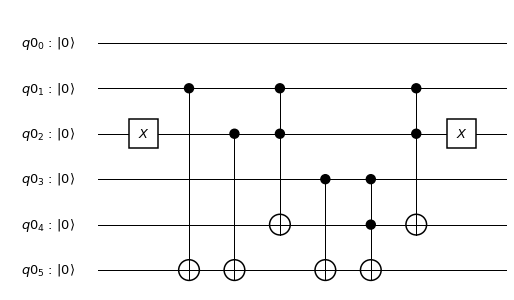

In [3]:
# declare variables
q = QuantumRegister(6)
qc = QuantumCircuit(q)

# store y to one of the qubit in qubit register
qc.x(q[2])
qc.cx(q[1], q[5])
qc.cx(q[2], q[5])
qc.cx(q[3], q[5])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[3], q[4], q[5])

# initialize all qubits to 0 except y, for subsequent use of sub-circuit
qc.ccx(q[1], q[2], q[4])
qc.x(q[2])

# draw the quantum circuit
qc.draw(output='mpl')

In the sub-circuit above, the three `ccx` gates on the right are used to compute $( q_1 \wedge \neg q_2 \wedge q_3)$ and write the result to $q_5$, while the three `cx` gates on the left are used to compute $q_1 \oplus \neg q_2 \oplus q_3$ and write the result to $q_5$. Notice that the right-most `ccx` gate is used to reset the value of $q_4$ so that it can be reused in the succeeding sub-circuits. 

From the above sub-circuit, we can define a blackbox function to check the solution of the Exactly-1 3-SAT problem as follows. Here, to expedite the process, we present a code to do this job. Make yourself understand how it works.

In [4]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function

## Inversion about the average

Another important procedure in Grover search is to have an operation that perfom the *inversion-about-the-average* step, namely, it performs the following transformation:

$$
\sum_{j=0}^{2^{n}-1} \alpha_j |j\rangle \rightarrow \sum_{j=0}^{2^{n}-1}\left(2 \left( \sum_{k=0}^{k=2^{n}-1} \frac{\alpha_k}{2^n} \right) - \alpha_j  \right) |j\rangle 
$$

The above transformation can be used to amplify the probability amplitude $\alpha_s$ when s is the solution and $\alpha_s$ is negative (and small), while $\alpha_j$ for $j \neq s$ is positive. Though it looks like complicated, note that the amplitude on right-hand side can be reexpressed as (average-a)+average. Think about why this does the inversion-about-the-average.

Roughly speaking, the value of $\alpha_s$ increases by twice the average of the amplitudes, while others are reduced. This is the key principle in glover search, and in general called amplitude amplification (see Wikipedia : https://en.wikipedia.org/wiki/Amplitude_amplification for more detail).

The inversion-about-the-average can be realized with the sequence of unitary matrices as below:

$$
U = H^{\otimes n} \left(2|0\rangle \langle 0 | - I \right) H^{\otimes n}
$$

The first and last $H$ are just Hadamard gates applied to each qubit. The operation in the middle requires us to design a sub-circuit that flips the probability amplitude of the component of the quantum state corresponding to the all-zero binary string. To see how it works, let's see it more closely.

1. Show that U is indeed unitary.
$$
U^\dagger = H^{\otimes n} \left(2|0\rangle \langle 0 | - I \right) H^{\otimes n}
$$
$$
U^\dagger U = I
$$


2. Let's assume 1 qubit case for simplicity. ($|\psi\rangle = a_0|0\rangle + a_1|1\rangle$) What should be the state after inversion-about-the-average? (Do not apply $U$ in this step, but calculate average and invert around it by hands)
$$U|\psi\rangle = a_1|0\rangle + a_0|1\rangle$$


3. Now we apply $U$ to $|\psi\rangle$, what's the state after applying only $H$ to $|\psi\rangle$?
$$H|\psi\rangle = \frac{(a_0+a_1)}{\sqrt{2}}|0\rangle + \frac{(a_0-a_1)}{\sqrt{2}}|1\rangle$$


4. What's the state after applying $\left(2|0\rangle \langle 0 | - I \right)$ to the result of 3? Does it change the sign of non-$|0\rangle$ term?
$$\left(2|0\rangle \langle 0 | - I \right)H|\psi\rangle = \frac{(a_0+a_1)}{\sqrt{2}}|0\rangle - \frac{(a_0-a_1)}{\sqrt{2}}|1\rangle$$


5. What's the state after applying $H$ to the result of 4? Does your answer match the answer of 2?
$$H\left(2|0\rangle \langle 0 | - I \right)H|\psi\rangle = a_1|0\rangle + a_0|1\rangle$$


The sub-circuit $\left(2|0\rangle \langle 0 | - I \right)$ can be realized by the following function, which is a multi-qubit controlled-Z which flips the probability amplitude of the component of the quantum state corresponding to the all-one binary string. Applying X gates to all qubits before and after the function realizes the sub-circuit. Here, we provide a n-controlled_Z(circuit, controls, target) below.
(See how it works.)

In [5]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

Finally, the inversion-about-the-average circuit can be realized by the following function. Fill the definition below following the comments:

In [6]:
def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # H gates for all qubits of f_in
    for j in range(n):
        circuit.h(f_in[j])
        
    # Implement the gates that flips the sign of |000> state only. (Use n-controlled_Z given above)
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
        
    # H gates for all qubits of f_in, again.
    for j in range(n):
        circuit.h(f_in[j])


Let's get the circuit diagram for the three qubit inversion-about-the-average.

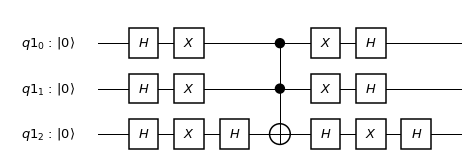

In [7]:
# creat three qubit inversion-about-the-average circuit and draw it.
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_average(qInvAvg, qr, 3)
qInvAvg.draw(output='mpl')

## Grover Search: putting all together

The complete steps of Grover search is as follow.

1. Create the superposition of all possible solutions as the initial state (with working qubits initialized to zero)
$$\sum_{j=0}^{7} \frac{1}{\sqrt{8}} |j\rangle |-\rangle$$,
where $|j\rangle$ are the qubits to be searched, and $|-\rangle$ is the ancilla qubit. (Blackbox flips the ancilla qubit when the search qubits satisfy the condition. By setting ancilla qubit to $|-\rangle$, the action of the blackbox changes into the sign change, $|-\rangle\rightarrow-|-\rangle$. 


2. Repeat for $T$ times:

    a) Apply the blackbox function
    
    b) Apply the inversion-about-the-average function
      
    
3. Measure to obtain the solution

The skeleton code for the above steps is as below. Fill the missing lines indicated by the comments.

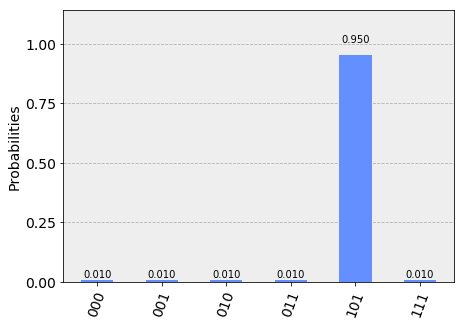

In [8]:
# create the circuit initializing the state.

def input_state(circuit, f_in, f_out, n):
    for j in range(n):
        circuit.h(f_in[j])
    #f_out is initialized into |->
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# We make three-qubit glover search circuit.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.

## ACTION REQUIRED!!! Declare f_in, f_out and aux. (size of aux should be 1 + (number or clauses))
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# ACTION REQUIRED!!! Define classical register ans for algorithm result
ans = ClassicalRegister(n)

# ACTION REQUIRED!!! Add registers to the quantum circuit "grover"
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

# Initialize the states (adding the initiailzation circuit to the "grover")
input_state(grover, f_in, f_out, n)

# We do the iteration only twice (T=2), since grover search requires about sqrt(N) cycles.
T = 2
for t in range(T):
    # ACTION REQUIRED!!! Type lines doing blackbox operation and the inversion_about_average.
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

for j in range(n):
    # ACTION REQUIRED!!! Measure the output register in the computational basis (store it in ans)
    grover.measure(f_in[j], ans[j])

# Execute circuit
## ACTION REQUIRED!!! Fill the correct backend
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=100)
result = job.result()

# ACTION REQUIRED!!! Get counts and plot histogram
counts = result.get_counts(grover)
plot_histogram(counts)

## References

[1] "[A fast quantum mechanical algorithm for database search](https://arxiv.org/abs/quant-ph/9605043)", L. K. Grover, Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996)

[2] "[Tight bounds on quantum searching](https://arxiv.org/abs/quant-ph/9605034)", Boyer et al., Fortsch.Phys.46:493-506,1998